In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from data.image import CS_Images
from data.config import BRAIN_VISA_PATH, CS_CORRECTED
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

import SimpleITK as sitk

from skimage import measure

import cv2

from utils.fs_mapping import fs_lut

from sklearn.neighbors import NearestNeighbors
from copy import deepcopy

from skimage import measure, morphology

from data.sulci_junctions import junction_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Loading and plotting data

In [2]:
cs_paths = [x for x in Path(BRAIN_VISA_PATH).glob(CS_CORRECTED)]
dataset = CS_Images(segmentation='all',
                    mesh=True,
                    preload=False)

Found 308 subjects and 308 MPRAGE images
Found 13 subjects with both BrainVisa and corrected from 308 subjects


In [3]:
dataset.get_caseidx('sub-via248')

(array([0]),)

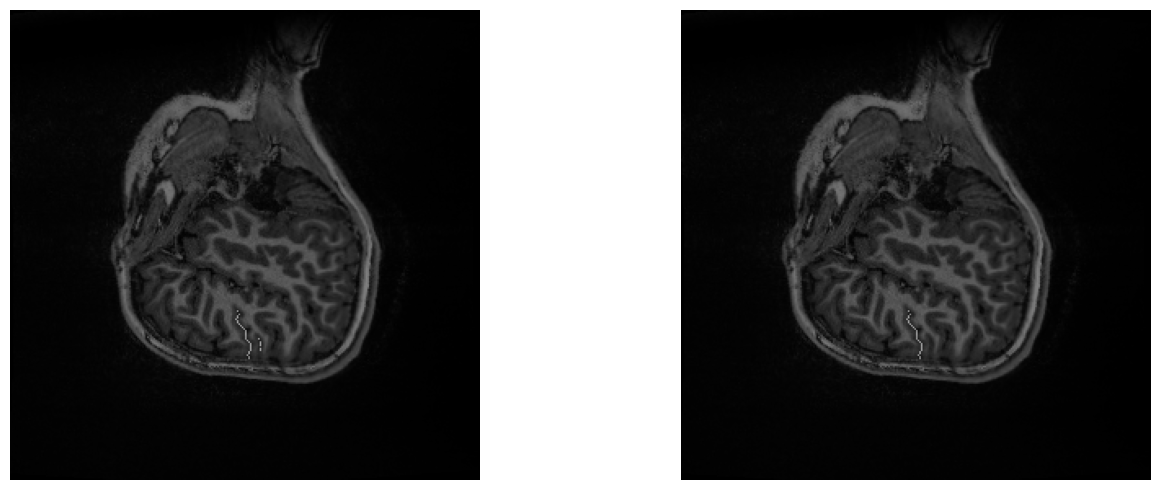

In [4]:
s0 = dataset[2]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']
slc = 150

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :], cmap='gray')
axs[0].imshow(bvisa[slc, :, :], alpha=0.5, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(img[slc, :, :], cmap='gray')
axs[1].imshow(corrected[slc, :, :], alpha=0.5, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [5]:
def touint8(img):
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

In [6]:
def img_mask_overlay(img, mask):
    mask = np.stack([mask, mask, mask], axis=-1).astype(np.bool_)
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    img[mask] = 255
    axs.imshow(img)
    axs.set_axis_off()
    plt.show()

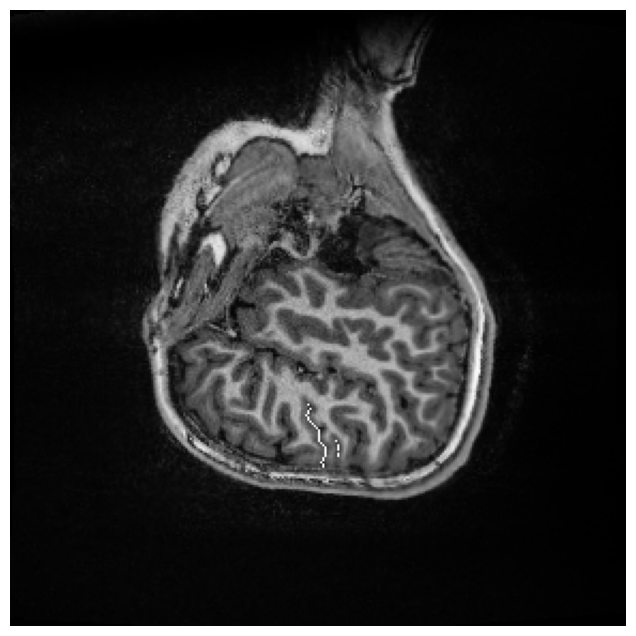

In [7]:
img_rgb = touint8(img[slc, :, :]) # np.stack([img[slc, :, :].T] * 3, axis=-1)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
mask = bvisa[slc, :, :]
img_mask_overlay(img_rgb, mask)

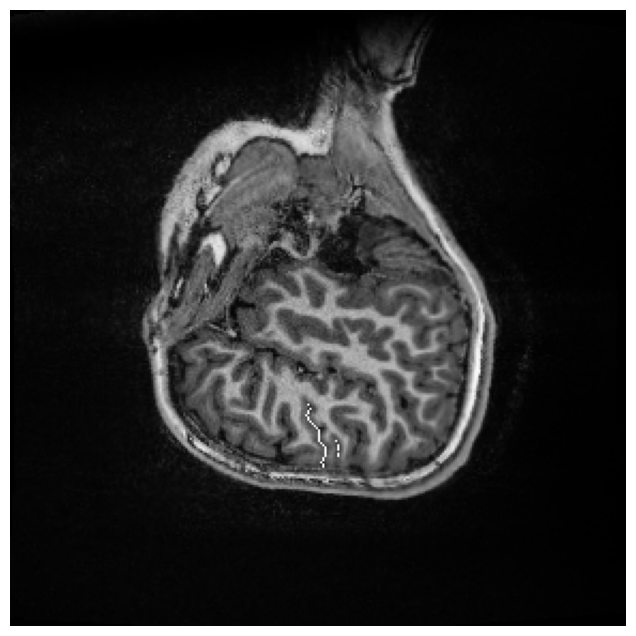

In [8]:
(new_mask, bgModel, fgModel) = cv2.grabCut(img_rgb, (mask!=0).astype(np.uint8), rect=None, bgdModel=None,
                                       fgdModel=None, iterCount=100, mode=cv2.GC_INIT_WITH_MASK)
img_mask_overlay(img_rgb, new_mask)

In [9]:
np.all(((mask !=0) == (new_mask!=0)))

True

In [10]:
caseid

'sub-via227'

## Load Segmentations

In [11]:
import nibabel as nb

In [12]:
segm_path = '/mnt/projects/VIA_Vlad/nobackup/MP2RAGE_FS7_2_0_samseg/via227/mri/samseg/seg.mgz'
segm = nb.load(segm_path)

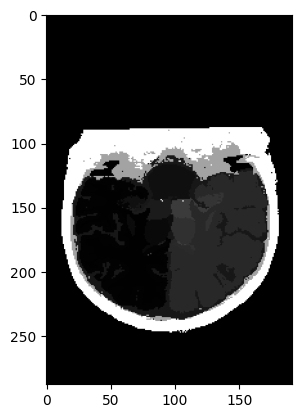

In [13]:
plt.imshow(segm.get_fdata()[slc, :, :], cmap='gray')

In [14]:
segm_array = segm.get_fdata()
np.unique(segm_array)

# 2: left ceribral white matter
# 3: left cerebral cortex
# 41: right cerebral white matter
# 42: right cerebral cortex

array([  0.,   2.,   3.,   4.,   5.,   7.,   8.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  24.,  26.,  28.,  30.,  31.,  41.,
        42.,  43.,  44.,  46.,  47.,  49.,  50.,  51.,  52.,  53.,  54.,
        58.,  60.,  62.,  63.,  77.,  80.,  85., 165., 258., 259.])

In [15]:
reg_params = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CFIN/sub-via227/t1mri/default_acquisition/registration/RawT1-sub-via227_default_acquisition_TO_Talairach-MNI.trm'

```
Tx Ty Tz
Rxx Rxy Rxz
Ryx Ryy Ryz
Rzx Rzy Rzz
```
With `R1_TO_R2.trm` meaning that the given tranformation matrix moves from R1 to R2 (aka `x2 = R*X1 + T`)

In [16]:
with open(reg_params, 'r') as f:
    transf_matrix = [[float(y.strip()) for y in x.split(' ')] for x in f.readlines()]

In [17]:
transf_matrix

[[86.3141, 115.605, 118.533],
 [-0.999999, -0.00172322, -1.08668e-05],
 [0.00172324, -0.999949, -0.00998452],
 [-6.33922e-06, 0.00998452, -0.99995]]

In [18]:
def transform_affine(image:sitk.Image, affmatrix:np.ndarray, interpolator=sitk.sitkBSpline):
    """Transform image with a given affine matrix

    Args:
        image (sitk.Image): Image to transform
        affmatrix (np.ndarray): Affine matrix of shape (4, 3) with the following format:
            Tx  Ty  Tz
            Rxx Rxy Rxz
            Ryx Ryy Ryz
            Rzx Rzy Rzz
        interpolator (_type_, optional): _description_. Defaults to sitk.sitkBSpline.

    Returns:
        _type_: _description_
    """
    reference_image = image
    tx, ty, tz = transf_matrix[0]
    rot00, rot01, rot02 = transf_matrix[1]
    rot10, rot11, rot12 = transf_matrix[2]
    rot20, rot21, rot22 = transf_matrix[3]
    # center = [0, 0, 0]

    sitk_aff_matrix = [rot00, rot01, rot02, rot10, rot11, rot12, rot20, rot21, rot22]
    transl_vector = [tx, ty, tz]
    # 3D affine transform
    transform = sitk.AffineTransform(3)
    
    # transform.SetMatrix(sitk_aff_matrix)
    transform.SetTranslation(transl_vector)
    # transform.SetCenter(center)
    
    return sitk.Resample(image, reference_image, transform, interpolator)

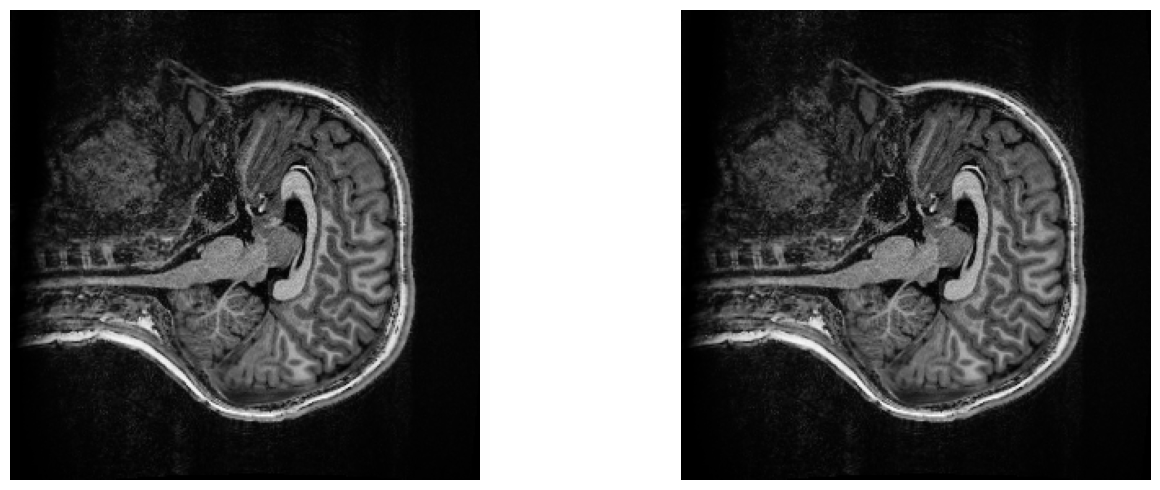

In [19]:
orig_img = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/mp2rage/CFIN/sub-via227_ses-01CFINskyra_acq-mp2rage_rec-nomoco_run-01_Robust.nii.gz')
orig_transformed = transform_affine(orig_img, transf_matrix)
orig_transformed_array = sitk.GetArrayFromImage(orig_img)
slc = 100

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(orig_transformed_array[slc, :, :].T, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

Samseg segmentation labels
```
2: left ceribral white matter
3: left cerebral cortex
41: right cerebral white matter
42: right cerebral cortex
165: skull
24: csf
````

In [20]:
labels = [segm_array.T[bvisa!=0]]
np.unique(labels, return_counts=True)

(array([  3.,  24.,  42., 165., 258.]), array([ 639, 2427,  618,  188,   56]))

In [21]:
from data.segmentation_properties import SegmAnalyzer
seg_analyzer = SegmAnalyzer()

In [22]:
bvisa = s0['bvisa']

In [23]:
i = 2

segm_properties = seg_analyzer.process(bvisa, caseid)
segm_properties

{'LCS_lebel2inters': {3: 639, 24: 1164, 165: 106, 258: 53},
 'RCS_lebel2inters': {24: 1263, 42: 618, 165: 82, 258: 3}}

In [24]:
ls = s0['bvisa_mesh_lscl']
ls.compute_triangle_normals()

TriangleMesh with 2534 points and 5068 triangles.

In [25]:
np.asarray(ls.vertices)

array([[103.09963226, 153.03022766,  48.92225266],
       [101.64877319, 153.72068787,  48.90235138],
       [102.81158447, 153.22976685,  49.68653107],
       ...,
       [145.605896  , 122.98443604, 100.54023743],
       [145.67419434, 124.07154083, 101.27624512],
       [146.50094604, 123.66139984, 101.64936066]])

In [26]:
np.asarray(ls.triangles)

array([[   0, 1522, 1523],
       [   0, 1523,    1],
       [   0,    1,  340],
       ...,
       [ 927, 2528, 2527],
       [ 927, 2532,  929],
       [1510, 2533, 2532]], dtype=int32)

In [27]:
triangle_normals = np.asarray(ls.triangle_normals)

In [73]:
triangles = np.asarray(ls.triangles)
vertices = np.asarray(ls.vertices)
edges = np.concatenate([triangles[:, [0, 1]],
                        triangles[:, [1, 2]],
                        triangles[:, [2, 0]]], axis=0)
edges = np.sort(edges, axis=1)
edges = np.unique(edges, axis=0)
edge_dihedral_angles = np.zeros((edges.shape[0]))
for edgidx, edg in enumerate(edges):
    t1n = triangle_normals[edg[0]]
    t2n = triangle_normals[edg[1]]
    edge_dihedral_angles[edgidx] = dihedral_angle(t1n, t2n)

dihedral_threshold_delta = 5
# dmask = (edge_dihedral_angles>90-dihedral_threshold_delta)&(edge_dihedral_angles<90+dihedral_threshold_delta)
dmask = (edge_dihedral_angles<10)
spiked_vertices = np.unique(edges[dmask].ravel())
len(spiked_vertices)/len(vertices)

0.39581689029202843

In [76]:
len(edge_dihedral_angles)

7602

In [74]:
new_cols = np.zeros((len(vertices), 3))
new_cols[:,:] = [0.5, 0.5, 0.5]
new_cols[spiked_vertices, :] = [1, 0, 0]
ls.vertex_colors = o3d.cuda.pybind.utility.Vector3dVector(new_cols)
o3d.visualization.draw_geometries([ls])

In [32]:
def get_spiked_vertices(mesh, threshold=30):
    """Spiked vertex is any vertex having at
        least one edge whose dihedral angle is
        greater (in absolutevalue) than a user-specified
        dihedral angle threshold
    """
    pass

In [58]:

dihedral_threshold_delta = 20
dmask = (edge_dihedral_angles>90-dihedral_threshold_delta)&(edge_dihedral_angles<90+dihedral_threshold_delta)
spiked_vertices = np.unique(edges[dmask].ravel())
len(spiked_vertices)/len(vertices)

0.6286503551696921

In [59]:
good_vertices = vertices[~np.isin(np.arange(len(vertices)), spiked_vertices)]

In [60]:
def weighted_sum(closest_neigb, distances):
    dist_norm  = distances/np.sum(distances)
    return np.mean(closest_neigb, axis=0)

In [61]:
N_NEIGHBORS = 3
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS+1, algorithm='ball_tree').fit(good_vertices)
spiked_vertices_coords = vertices[spiked_vertices]
distances, indices = nbrs.kneighbors(spiked_vertices_coords)
spiked_vertices_coords_smoothed = [weighted_sum(good_vertices[indices[i][1:],:], distances[i, 1:]) for i in range(len(distances))]

In [62]:
o3d.visualization.draw_geometries([ls])

smoothed_restored = deepcopy(ls)
reconstr_vertices = np.asarray(smoothed_restored.vertices)
reconstr_vertices[spiked_vertices, :] = spiked_vertices_coords_smoothed
smoothed_restored.vertices = o3d.cuda.pybind.utility.Vector3dVector(reconstr_vertices)
o3d.visualization.draw_geometries([smoothed_restored])


## Branching statistics

In [25]:
def cvshow(img):
    # imgslice = 255*(img>0)
    imgslice = img
    imgslice = imgslice.astype(np.uint8)
    cv2.imshow("test", imgslice)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [29]:
bvisa = sitk.GetArrayFromImage(s0['bvisa'])

In [30]:
slc = 43
imgslice = touint8(bvisa[slc, :, :].T)
cvshow(imgslice)
imgslice_thinned = cv2.ximgproc.thinning(imgslice)
cvshow(imgslice_thinned)


In [38]:
junc1 = [[0, -1,  0],
         [1,  1,  1],
         [-1,  1,  0]]

junc2 = [[0, -1,  0],
		 [1,  1,  1],
		 [0,  1, -1]]

junc3 = [[1, -1, -1],
         [-1, 1, 1],
         [-1, 1, -1]]

junctions_fbank = [np.rot90(junc1, k) for k in range(4)] + [np.rot90(junc2, k) for k in range(4)] + [np.rot90(junc3, k) for k in range(4)]

def find_junctions(imgslice, junctions_fbank):
    res = np.zeros_like(imgslice)
    imgslice_thinned = cv2.ximgproc.thinning(imgslice)
    for f in junctions_fbank:
        res += cv2.morphologyEx(imgslice_thinned, cv2.MORPH_HITMISS, f)
    return res > 0

junction_img = np.zeros_like(bvisa)
for sl in range(bvisa.shape[0]):
    junction_img[sl, :, :] = find_junctions(touint8(bvisa[sl, :, :]), junctions_fbank)
    

/tmp/ipykernel_2739490/1540041611.py:2: RuntimeWarning: invalid value encountered in divide
  return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
/tmp/ipykernel_2739490/1540041611.py:2: RuntimeWarning: invalid value encountered in cast
  return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)


Found 24 junctions


In [47]:
se_cross3d = np.zeros((3, 3, 3))
se_cross3d[0, 1, 1] = 1
se_cross3d[1, :, 1] = 1
se_cross3d[1, 1, :] = 1

se_cross3d[2, 1, 1] = 1

# use to connect but assign labels based on original junctions mask
junction_img_dilated = morphology.binary_dilation(junction_img, se_cross3d)
junction_img_dilated_labeled = measure.label(junction_img_dilated, connectivity=2)
print(f'Found {len(np.unique(junction_img_dilated_labeled)) - 1} junctions')
print(np.unique(junction_img_dilated_labeled, return_counts=True))

Found 5 junctions
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([15923579,      100,     1083,       88,      335,       63]))


In [48]:
junction_sitk = sitk.GetImageFromArray(junction_img_dilated_labeled.astype(np.uint8))
junction_sitk.CopyInformation(s0['bvisa'])
sitk.WriteImage(junction_sitk, 'junctions227.nii.gz')

In [50]:
bvisa_junct_split = bvisa.copy()
bvisa_junct_split[junction_img>0] = 0
# bvisa_junct_split = morphology.skeletonize(bvisa_junct_split)
bvisa_junct_split_cc = morphology.label(bvisa_junct_split, connectivity=2)
print(np.unique(bvisa_junct_split_cc, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([15921612,     1630,       50,       10,       41,        1,
           1805,       37,       62]))


In [53]:
bvisa_dil = morphology.binary_closing(bvisa, se_cross3d)
bvisa_cc = morphology.label(bvisa_dil, connectivity=2)
print(np.unique(bvisa_cc, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int32), array([15921212,     2022,     1914,       37,       63]))


In [5]:
junction_img_dilated_labeled = junction_image(bvisa)

In [23]:
lstats = dict(zip(*np.unique(junction_img_dilated_labeled, return_counts=True)))
lstats = {k:v for k,v in lstats.items() if k!=0 and v>1}

In [27]:
a = np.zeros((1,2,3))

In [28]:
a.shape

(1, 2, 3)

In [29]:
a.T.shape

(3, 2, 1)

In [8]:
print(f'Found {len(np.unique(junction_img_dilated_labeled)) - 1} junctions')
print(np.unique(junction_img_dilated_labeled, return_counts=True))

Found 12 junctions
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([15925205,        2,       12,        7,        3,        1,
              3,        5,        2,        1,        3,        3,
              1]))


In [6]:
junction_sitk = sitk.GetImageFromArray(junction_img_dilated_labeled.astype(np.uint8))
junction_sitk.CopyInformation(s0['bvisa'])
sitk.WriteImage(junction_sitk, 'junctions227.nii.gz')